# Graphical Models: Similarity Distribution Experimentation

In [1]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
import random

## Similarity Implementations

### General Methods

In [2]:
# get all children in a dictionary including their respective weights (chains taken into account)
def get_all_children(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_all_children(graph, i[1], children_dict=children_dict, carry=weights[i])
    return children_dict

In [3]:
# (Adapted from function above)
# Get all children in a dictionary including their respective weights (chains taken into account)
def get_descendants(graph, parent, children_dict={}, carry=1):
    weights = nx.get_edge_attributes(graph, 'weight')
    
    for i in graph.out_edges(parent):
        children_dict[i[1]] = carry*weights[i]
        get_descendants(graph, i[1], children_dict=children_dict, carry=weights[i])
    
    return children_dict

In [4]:
# Returns children of a single node
def get_children(gm, parent):
    children_weights = {}
    weights = nx.get_edge_attributes(gm, 'weight')
    
    for i in gm.out_edges(parent):
        children_weights[i[1]] = weights[i]

    return children_weights

In [5]:
def find_node_children_subgraph(graph, snode, childgraph):
    cnodes = graph.neighbors(snode)
    edges = nx.edges(graph)
    for i in cnodes:
        childgraph.add_node(i)
        childgraph.add_edge(snode, i)
        childgraph = find_node_children_subgraph(graph, i, childgraph)
    return childgraph

### Jaccard Index

In [6]:
# all children of rain
def calculate_intersection(graph, children_a, children_b):
    inter = 0
    for i in children_a:
        if i in children_b:
            if children_a[i] < children_b[i]:
                inter += children_a[i]
            else:
                inter += children_b[i]
    return inter  

In [7]:
# helper func to calculate the union using method 1
def calculate_union_1(graph, children_a, children_b):
    union = 0
    for i in children_a:
        union += children_a[i]
    for i in children_b:
        union += children_b[i]
    union -= calculate_intersection(graph, children_a, children_b)
    return union

In [8]:
# helper func to calculate the union using method 2
def calculate_union_2(graph, children_a, children_b):
    union = 0
    for i in children_a:
        if i in children_b:
            union += abs(children_a[i] - children_b[i])
        else:
            union += children_a[i]
    for i in children_b:
        if not i in children_a:
            union += children_b[i]
    return union

In [9]:
# calculate the similarity, compares both methods
def calculate_similarity(graph, node_a, node_b):
    children_a = get_all_children(g, node_a, {})
    children_b = get_all_children(g, node_b, {})
    intersection = calculate_intersection(graph, children_a, children_b)
    union_1 = calculate_union_1(graph, children_a, children_b)
    union_2 = calculate_union_2(graph, children_a, children_b)
    results = {"method 1": intersection/union_1, "method 2": intersection/union_2}
    return results

### Edit-Distance

Edit-distance similarity implementation based only on a node's children.

In [10]:
# Returns the similarity of node B compared to node A, based on 
# children
def get_immediate_similarity(gm, A, B):
    cost = 0.0
    A_children = get_children(gm, A)
    B_children = get_children(gm, B)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    
    return cost / len(A_children)

In [11]:
# Returns the node that is most similar to the input node
def find_most_immediate_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_immediate_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_immediate_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

Edit-distance similarity implementation based on all descendants of a node.

In [12]:
# Returns the similarity of node B compared to node A
def get_full_similarity(gm, A, B):
    cost = 0.0
    A_children = get_descendants(gm, A, {}, 1)
    B_children = get_descendants(gm, B, {}, 1)
    
    for child in A_children:
        if child in B_children:
            diff = abs(A_children[child] - B_children[child])
            cost += diff
        else:
            cost += 1
    return cost / len(A_children)

# Optional print line in for loop for debugging: 
# print(child, A_children[child], B_children[child])

In [13]:
# Returns the node that is most similar to the input node
def find_most_similar(gm, A):
    nodes = list(gm.nodes)
    nodes.remove(A)
    
    max_similarity = get_full_similarity(gm, A, nodes[0])
    max_sim_node = nodes[0]
    for node in nodes:
        node_similarity = get_full_similarity(gm, A, node)
        
        if node_similarity < max_similarity:
            max_sim_node = node
            max_similarity = node_similarity
    
    return max_sim_node

### NetworkX: Edit-Distance

In [14]:
# nx.graph_edit_distance(Graph1, Graph2)

### NetworkX: SimRank

In [15]:
# nx.algorithms.similarity.simrank_similarity(graph, source="node_a", target="node_b")

## Generating Random Directed Graphs

In [16]:
def addNodes(gm, num_nodes):
    node_list = []
    
    for i in range(num_nodes):
        gm.add_node(i)

    return gm

In [17]:
def addEdges(gm, num_nodes, num_edges):
    for i in range(num_edges):
        parent = random.randrange(num_nodes)
        child = random.randrange(num_nodes)
        
        while (child == parent):
            child = random.randrange(num_nodes)
        
        conditional_prob = random.uniform(0, 1)
        gm.add_edge(parent, child, weight=conditional_prob)
    
    return gm

In [18]:
def makeDirectedGraph(num_nodes, num_edges):
    dg = nx.DiGraph() # creates directed graph
    dg = addNodes(dg, num_nodes)
    dg = addEdges(dg, num_nodes, num_edges)
    return dg

In [19]:
def makeDirectedPath(num_nodes):
    pdg = nx.path_graph(num_nodes, create_using=nx.DiGraph())
    for i in pdg.edges():
        pdg.edges[i[0], i[1]]['weight'] = weight=random.uniform(0, 1)
    return pdg

## Experiment

### make directed graph

In [20]:
g = makeDirectedGraph(15, 17)
nx.edges(g)

OutEdgeView([(0, 2), (0, 11), (2, 5), (4, 13), (5, 8), (6, 11), (7, 2), (8, 6), (8, 10), (9, 4), (9, 13), (10, 3), (12, 8), (12, 4), (13, 1), (13, 10), (14, 11)])

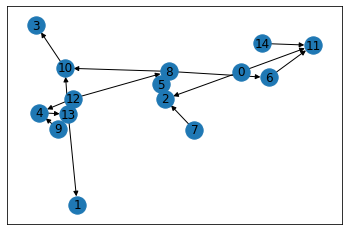

In [21]:
nx.draw_networkx(g)

In [22]:
nx.get_edge_attributes(g, 'weight')

{(0, 2): 0.42620444889941467,
 (0, 11): 0.44898337860413107,
 (2, 5): 0.8173218505188634,
 (4, 13): 0.5647860554169981,
 (5, 8): 0.6455278459520111,
 (6, 11): 0.3462497799364147,
 (7, 2): 0.169323524920993,
 (8, 6): 0.8107382255535125,
 (8, 10): 0.7671981587891216,
 (9, 4): 0.019561439367124067,
 (9, 13): 0.9413909017248108,
 (10, 3): 0.3483222414632309,
 (12, 8): 0.11548988932050419,
 (12, 4): 0.7979764561486962,
 (13, 1): 0.06523952330699234,
 (13, 10): 0.2884855443603209,
 (14, 11): 0.27354458483082456}

In [23]:
# clique size
import itertools as it
from networkx.algorithms import approximation
from networkx.algorithms.approximation import clique

In [24]:
max_clique = clique.max_clique(g)
print(max_clique)

{9, 13}


# Similarity Implementation: Edit-Distance

In [25]:
list_max_clique  = list(max_clique)
A = list_max_clique[0]
B = list_max_clique[1]

print(A)
print(B)

9
13


In [26]:
a = get_all_children(g, A)
a

{4: 0.019561439367124067,
 13: 0.9413909017248108,
 1: 0.06141589367406633,
 10: 0.2715776667399354,
 3: 0.10048593144132731}

In [27]:
b = get_all_children(g,B)
b

{4: 0.019561439367124067,
 13: 0.9413909017248108,
 1: 0.06523952330699234,
 10: 0.2884855443603209,
 3: 0.10048593144132731}

Edit distance by a node's child

In [28]:
get_immediate_similarity(g, A, B)

1.0

In [29]:
find_most_immediate_similar(g, A)

4

In [30]:
#find_most_immediate_similar(g, B)

In [31]:
nodes = list(g.nodes)
nodes.remove(A)

for node in nodes:
    node_similarity = get_immediate_similarity(g, A, node)
    print("Node:", node)
    print("Similarity:", node_similarity)
    print()

Node: 0
Similarity: 1.0

Node: 1
Similarity: 1.0

Node: 2
Similarity: 1.0

Node: 3
Similarity: 1.0

Node: 4
Similarity: 0.6883024231539063

Node: 5
Similarity: 1.0

Node: 6
Similarity: 1.0

Node: 7
Similarity: 1.0

Node: 8
Similarity: 1.0

Node: 10
Similarity: 1.0

Node: 11
Similarity: 1.0

Node: 12
Similarity: 0.889207508390786

Node: 13
Similarity: 1.0

Node: 14
Similarity: 1.0



Edit-distance similarity implementation based on all descendants of a node.

In [32]:
A_desc = get_descendants(g, A)
A_desc

{4: 0.019561439367124067,
 13: 0.9413909017248108,
 1: 0.06141589367406633,
 10: 0.2715776667399354,
 3: 0.10048593144132731}

In [33]:
B_desc = get_descendants(g, B)
B_desc

{4: 0.019561439367124067,
 13: 0.9413909017248108,
 1: 0.06523952330699234,
 10: 0.2884855443603209,
 3: 0.10048593144132731}

In [34]:
get_full_similarity(g, A, B)

0.40414630145066227